### Portfolio allocation using Markowitz mean-variance model and nested clustered optimization

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns 
import matplotlib.pyplot as plt

from scipy.optimize import minimize, LinearConstraint
from sklearn.neighbors import KernelDensity
from sklearn.metrics import mean_squared_error, silhouette_samples
from sklearn.cluster import KMeans

from typing import Tuple, Callable, Literal, Union

from datetime import datetime as dt

sns.set()
np.random.seed(7)

In [2]:
df = pd.read_csv('indices.csv')
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

df.head()

,Argentina: BNY Mellon Argentina ADR,Argentina: BNY Mellon Argentina ADR TR,Argentina: S&P Merval,Argentina: S&P/BYMA Argentina General,Australia: ASX All Ordinaries,Australia: ASX All Ordinaries Gold,Australia: ASX Small Ordinaries,Australia: BNY Mellon Australia ADR,Australia: BNY Mellon Australia ADR TR,Australia: FTSE Australia,...,World: TR/CC CRB Soybeans,World: TR/CC CRB Sugar,World: TR/CC CRB TR,World: TR/CC CRB Unleaded Gas,World: TR/CC CRB Wheat,World: TR/CC CRB ex Energy ER,World: TR/CC CRB ex Energy TR,World: WTI Futures Long USD,World: World Water CW,World: World Water TR CW
Date,,,,,,,,,,,,,,,,,,,,,
2012-01-02,67.987712,96.175352,1183.707845,71550.898756,3259.150352,5306.428352,1633.480771,223.303644,355.339260,265.228248,...,12.018717,19.151213,268.241778,14.954768,3.574582,155.078519,276.749408,702.333321,1416.096473,1803.912911
2012-01-03,70.257200,99.386961,1234.451984,73815.487325,3264.193677,5370.440733,1645.534166,223.303644,355.339260,268.076305,...,12.215584,20.145613,268.241778,15.467880,3.597938,155.078519,276.749408,731.683221,1424.253604,1814.305272
2012-01-04,72.825517,103.022668,1305.235178,76443.479483,3330.424627,5450.592434,1670.697370,224.047760,356.519720,273.939950,...,12.240192,20.070904,268.601054,15.681048,3.559719,154.415102,275.583209,733.533215,1447.814903,1844.307787
2012-01-05,72.817440,103.014433,1305.105397,76255.341385,3296.716050,5411.204191,1660.808157,220.499430,350.872840,270.948295,...,12.031021,20.070904,264.101558,15.412230,3.446122,154.415102,275.583209,723.511820,1447.359857,1843.729015
2012-01-06,73.786617,104.381426,1331.330652,76983.633861,3271.444438,5450.964348,1649.737815,217.082009,345.439961,268.610814,...,11.906749,20.209615,264.905651,15.500893,3.421704,154.761951,276.219393,721.733255,1447.486259,1843.890730


We make orders only once, so to cope with NaNs we could simply use linear interpolation

In [3]:
df = df.interpolate(method='linear', limit_direction='both')

## Portfolio allocation

For the portfolio allocation we will use Markowitz's mean-variance model:

We consider a universe of $n$ assets. Let $w = (w_1, w_2, \dots w_n)$ be the vector of weights in the portfolio. We assume, that portfolio is fully invested: $1_n^T w = 1$. We denote $r = (r_1, r_2 \dots r_n)$ be the vector of returns. 

The return of the portfolio is equal $r(w) = w^T r$. Let $\mu = E[r]$ be the vector of expected returns, $V$ be the covariance matrix of assets returns.
$\mu(w) = w^T \mu$. Variance $\sigma^2(w) = E[(r(w) - \mu(w)(r(w) - \mu(w))^T)] = w^T V w$.



Markowitz (1952) formulated the investor's financial problem as follows:
1. Maximizing the expected return of the portfolio under a volatility constraint ($\sigma$-problem) $$max \,\, \mu(w) \,\, s.t. \,\, \sigma(w) \le \sigma^*$$

2. Or minimizing the volatility of the portfolio under a return constraint ($\mu$-problem) $$min \,\, \sigma(w) \,\, s.t. \,\, \mu(w) \ge \mu^*$$

Markowitz's bright idea was to consider a quadratic utility function: $$U(w) = w^T \mu - \frac{\phi}{2} w^T Vw$$
where $\phi \ge 0$ is the risk aversion. So, Markowitz's problems ($\sigma$-problem and $\mu$-problem) cat be cast to  $$min \,\, -U(w) \,\, s.t. \,\, 1_n^T w = 1$$.

Also, we add L2 regularization term, it encourages diversification, so our optimization problem is: $$min \,\, -U(w) + \gamma \cdot w^T w \,\, s.t. \,\, 1_n^T w = 1$$

We will take this model as our allocation method

### Expected returns 
There is at least 2 approaches for estimating expected returns:

1. Expected returns is the mean of historical returns.
2. Calculate expected returns using exponential moving average, it gives more weights to recent returns and thus aims to increase the relevance of estimates.

We will try all of these 2 approaches.

In [4]:
def create_loss(
    mu: np.ndarray, 
    cov: np.ndarray, 
    risk_aversion: float = 1., 
    gamma: float = 1.) -> Callable:
    """
    Function for creating loss function which will be minimized.

    args:
        mu: expected return
        cov: covariance matrix of returns
        risk_aversion: float number characterized model attention to risk reduction instead of return increase
        gamma: weigth of L2 regularization

    returns:
        loss function to minimize.
    """
    mu = mu.to_numpy()
    cov = cov.to_numpy()
    
    def loss(w):
        return -(np.dot(w, mu) -  (risk_aversion / 2) * np.dot(w.T, cov).dot(w)) + gamma * np.dot(w.T, w)

    return loss

In [5]:
def prices2returns(prices: pd.DataFrame) -> pd.DataFrame:
    """
    Converts prices to returns.

    args:
        prices: prices
    
    returns:
        prices returns.
    """
    return prices.pct_change().fillna(value=0.)


In [6]:
def mean_return(prices: pd.DataFrame) -> pd.Series:
    """
    Calculates returns using geometric mean.

    args:
        prices: prices dataframe

    returns:
        array containing return of each stock.
    """
    returns = prices2returns(prices)
    return 100 * ((1 + returns).prod()**(1 / returns.count()) - 1) # scaling to deal with gradient vanishing in optimization methods


def ema_return(prices: pd.DataFrame, span: int = 500) -> pd.Series:
    """
    Calculates returns using exponential moving average.

    args:
        prices: prices dataframe
        span: time-span for the ema in days.

    returns:
        array containing return of each stock.
    """
    returns = prices2returns(prices)
    return 100 * ((1 + returns.ewm(span=span).mean().iloc[-1]) - 1) # scaling to deal with gradient vanishing in optimization methods

In [7]:
def covariance_matrix(prices: pd.DataFrame) -> pd.DataFrame:
    """
    Calculates covariance matrix.

    args:
        prices: prices dataframe

    returns:
        covariance matrix.
    """
    returns = 10 * prices2returns(prices) # scaling to deal with gradient vanishing in optimization methods
    return returns.cov()

In [8]:
def allocate_weights(
    mu: np.ndarray, 
    cov: np.ndarray,
    risk_aversion: float = 1., 
    gamma: float = 1.,
    ) -> np.ndarray:
    """
    Allocates portfolio weights by given expected returns and returns covariance matrix.

    args:
        mu: expected returns
        cov: returns covariance matrix
        risk_aversion: float number characterized model attention to risk reduction instead of return increase
        gamma: weigth of L2 regularization
    
    returns:
        portfolio weights.
    """
    n = mu.shape[0]
    linear_constr = LinearConstraint(np.ones((1, n)), [1.], [1.])
    loss = create_loss(mu, cov, risk_aversion=risk_aversion, gamma=gamma)

    out = minimize(loss, x0=np.asarray([1 / n] * n), bounds=[(0., 1.)] * n, constraints=linear_constr)

    if not out['success']:
        raise RuntimeError("Minimum wasn't found")
    
    return out['x']

In [9]:
def expected_returns(prices: pd.DataFrame, method: Literal['mean', 'ema']='mean') -> np.ndarray:
    """
    Computes expected returns.

    args:
        prices: Dataframe of stock's prices; rows - dates, columns - stocks 
        method: method for computation

    returns:
        expected returns.
    """
    if method == 'mean':
        return mean_return(prices)
    elif method == 'ema':
        return ema_return(prices)
    else: 
        raise NotImplementedError(f"Method {method} is not implemented")

In [10]:
def calculate_weights(
    prices: pd.DataFrame,
    risk_aversion: float = 1.,
    expected_return_method: Literal['mean', 'ema']='mean',
    gamma: float = 1.,
    ) -> np.ndarray:
    """
    Calculates weights for stocks in portfilio.

    args: 
        prices: Dataframe of stock's prices; rows - dates, columns - stocks
        risk_aversion: float number characterized model attention to risk reduction instead of return increase
        expected_return_method: method for calculating expected returns
        gamma: weigth of L2 regularization

    returns:
        array of stock's weights.
    """
    mu = expected_returns(prices, expected_return_method)
    cov = covariance_matrix(prices)

    return allocate_weights(mu=mu, cov=cov, risk_aversion=risk_aversion, gamma=gamma)


## Nested clustered optimization

1. Denoise correlation matrix
2. Cluster data regarding to correlation matrix
3. Compute optimal intracluster allocations
4. Compute optimal intercluster allocations
5. Combine allocations together

In [11]:
def cov2corr(cov: np.ndarray) -> np.ndarray:
    # on diagonals cov(x, x) = var(x)
    std = np.sqrt(np.diag(cov))
    corr = cov / np.outer(std, std)
    # for numerical errors:
    corr[corr < -1.] = -1.
    corr[corr > 1.] = 1. 
    return corr


def corr2cov(corr: np.ndarray, std: np.ndarray) -> np.ndarray:
    return corr * np.outer(std, std)

### Denoising correlation matrix

We want to denoise correlation matrix before clustering

How to denoise? 

The empirical correlation matrices have noise and signal, we want to find eigenvalues which associated with noise, in order to do this, we could fit the Marchenko-Pastur distribution's variance to the variance of our empirical matrix eigenvalues.

---
***Marchenko-Pastur distribution***

Consider a matrix of independent and identically distributed random observations
$X$, of size $p \times n$, where the underlying process generating the observations has zero mean and variance $\sigma^2$.

The matrix $C = \frac{1}{p} X^{T} X$ has eigenvalues $\lambda$ that asymptotically converge (as $n \rightarrow +\infty$ and $p \rightarrow +\infty$ with $1 < \frac{p}{n} < +\infty$) to the Marchenko-Pastur probability density function: 


$$
f(x) =  \frac{1}{2 \pi \lambda \sigma^2 \cdot x} \cdot \sqrt{(\lambda_{+} - x)(x - \lambda_{-})}, x \in [\lambda_{-}, \lambda_{+}]
$$


where: $\lambda_{-} = \sigma^2(1 - \sqrt{\lambda})^2, \lambda_{+} = \sigma^2(1 + \sqrt{\lambda})^2, \lambda = \frac{n}{p}$ 

---
Now eigenvalues in $[\lambda_{-}, \lambda_{+}]$ are consistent with random behaviour, specifically we will associate eigenvalues in $[0, \lambda_+]$ with noise.

How to use information about eigenvalues for denoising? 

---
***Constant residual eigenvalue method***

We will denoise correlation matrix by setting a constant eigenvalue instead of all eigenvalues, which associated with noise.


Let $\{\lambda_k\}_{k = 1 \dots n}$ be descending ordered set of all eigenvalues, and $i$ be the position of the eigenvalue such that $\lambda_i > \lambda_+$ and $\lambda_{i+1} \le \lambda_+$, then we set $\lambda_j = \frac{\sum_{k = i + 1}^n \lambda_k}{n - i}, j = i+1 \dots n$, in other words set all noise eigenvalues by their mean value.

This method preserves the trace.

Given the eigenvector decomposition of our correlation matrix $C = W \Lambda W^{-1}$, we form the denoised correlation matrix $C_1$ as 

$\tilde{C_1} = W \tilde{\Lambda} W^{-1} = W \tilde{\Lambda} W^T$ last equation holds because correlation matrix is symmetric and so its eigenvectors are orthogonal.

Scaling, so that the main diagonal is an array of 1s: 

$C_1 = \tilde{C_1} \cdot [diag(\tilde{C_1})^{\frac{1}{2}} \cdot diag(\tilde{C_1})^{\frac{1}{2}^T}]^{-1}$

In [12]:
def eig_decomposition(matrix: np.ndarray) -> Tuple[np.ndarray, np.ndarray]: 
    """
    Eigendecomposition.

    args: 
        matrix: Hermitian matrix

    returns:
        diagonalised matrix and matrix of eigenvectors, eigenvalues on diagonal are in descending order.
    """
    eigen_values, eigen_vectors = np.linalg.eigh(matrix)
    eigen_values, eigen_vectors = eigen_values[::-1], eigen_vectors[:, ::-1] # descending order
    return np.diag(eigen_values), eigen_vectors


def mpPDF(var: float, lamb: float, num_points: int = 100) -> pd.Series:
    """
    Function for generating points from Marchenko-Pastur distribution.

    args: 
        var: variance
        lamb: parameter, equals n / p, where p - number of stocks, n - number of observations
        num_points: number of points to generate

    returns:
        array of generated points.
    """
    lamb_min = var * (1 - lamb**0.5)**2
    lamb_max = var * (1 + lamb**0.5)**2

    values = np.linspace(lamb_min, lamb_max, num_points)
    pdf = ((lamb_max - values) * (values - lamb_min))**0.5 / (2 * np.pi * var * values * lamb)
    return pd.Series(pdf, index=values)


def loss(
    var: np.ndarray, 
    lamb: float, 
    kde: KernelDensity, 
    num_points: int = 1000, 
    loss_fn: Callable = mean_squared_error
    ) -> float:
    """
    Calculates loss between empirical and theoretical distributions.

    args:
        var: variance of theoretical distribution, np.ndarray of 1 elem for using with scipy.optimize.minimize
        lamb: parameter of distribution
        kde: KDE fitted on empirical data

    returns:
        loss between estimated and real points.
    """
    var = var[0]
    theoretical_pdf = mpPDF(var, lamb, num_points)
    x = theoretical_pdf.index.values.reshape(-1, 1)
    empirical_pdf = np.exp(kde.score_samples(x))

    return loss_fn(theoretical_pdf.to_numpy(), empirical_pdf)


def find_max_eigen_val(
    eigen_values: np.ndarray, 
    lamb: float, 
    bandwidth: float = 0.01,
    kernel: str = 'gaussian'
    ) -> Tuple[float, float]:
    """
    Fits Marchenko-Pastur distribution to given eigen values and 
    returns maximum random eigen_value (lambda_{+}) and found variance.

    args:
        eigen_values: empirical eigen values to fit MP distribution for
        lamb: param of distribution, equals n / p
        bandwidth: bandwidth of the kernel which will be fitted
        kernel: kernel to use

    returns:
        (lambda_{+}, variance of fitted MP distribution)
    """
    kde = KernelDensity(bandwidth=bandwidth, kernel=kernel).fit(eigen_values.reshape(-1, 1))

    out = minimize(lambda *x: loss(*x), 0.5, args=(lamb, kde), bounds=((1e-5, 1 - 1e-5),))
    if out['success']:
        var = out['x'][0]
    else:
        var = 1.
    
    eigen_max = var * (1 + lamb**0.5)**2
    return eigen_max, var


def constant_residual_eigen_denoise(
    eigen_values: np.ndarray, 
    eigen_vectors: np.ndarray, 
    n_facts: int
    ) -> np.ndarray:
    """
    Denoises correlation matrix by constant residual eigenvalue method.

    args:
        eigen_values: diagonal matrix of correlation matrixe's eigen values
        eigen_vectors: array of correlation matrix eigen vectors
        n_facts: number of columns, which contains some signal

    returns:
        denoised correlation matrix.
    """
    eigen_values_ = np.diag(eigen_values).copy() # np.diag returns reference or copy depends on numpy version
    eigen_values_[n_facts:] = eigen_values_[n_facts:].sum() / (eigen_values.shape[0] - n_facts)
    eigen_values = np.diag(eigen_values_)

    # cov2corr for scaling
    return cov2corr(np.dot(eigen_vectors, eigen_values).dot(eigen_vectors.T))


def denoise_corr(
    corr: np.ndarray,
    lamb: float,
    bandwidth: float = 0.01,
    kernel: str = 'gaussian'
    ) -> np.ndarray:
    """
    Denoises correlation matrix.

    args:
        corr: correlation matrix
        lamb: param of Marchenko-Pastur distribution, equals n / p
        bandwidth: bandwidth of the kernel which will be fitted in KDE
        kernel: kernel to use in KDE

    returns:
        denoised correlation matrix.
    """
    diag, eigen_vectors = eig_decomposition(corr)
    eigen_values = np.diag(diag)
    eigen_max, var = find_max_eigen_val(eigen_values, lamb=lamb, bandwidth=bandwidth, kernel=kernel)
    n_facts = eigen_values.shape[0] - eigen_values[::-1].searchsorted(eigen_max)
    return constant_residual_eigen_denoise(diag, eigen_vectors, n_facts)


### Clustering

Now we have denoised correlation matrix and it defines metric on our stock space. 

For the clustering we could follow at least 3 approaches:
1. Directly define distance matrix $d_{ij} = \sqrt{\frac{1}{2}(1 - c_{ij})}$, where $c_{ij}$ is correlation between $stock_i$ and $stock_j$
2. Use the correlation matrix instead of our observation matrix. Instead of $stock_i$ we will use $c_i$
3. Derive the observation matrix as $x_{ij} = \sqrt{\frac{1}{2}(1 - c_{ij})}$

The advantage of options 2 and 3 is that the distance between 2 variables will be a function of multiple correlation estimates, and not only one, which makes the analysis more robust to outliers. The advantage of option 3 is that change from $c_{ij} = 0.9$ to $c_{ij} = 1$ is greater than a change from $c_{ij} = 0.1$ to $c_{ij} = 0.2$, so we will follow 3rd approach.

\
We will use [K-Means](https://medium.com/data-folks-indonesia/step-by-step-to-understanding-k-means-clustering-and-implementation-with-sklearn-b55803f519d6) clustering. It has 2 notable limitations: first, the algorithm requires an user-set number of clusters; second, the initialization is random and so the effectiveness of the algorithm can be random.

To adress first concern, we define objective function, so that we can find the optimal number of clusters. For this, we choose the silhouette score:
$S_i = \frac{b_i - a_i}{max(a_i, b_i)}$, where $a_i$ is the average distance between i-th element and all other elements in the ***same*** cluster, $b_i$ is the average distance between i-th element and all elements of ***nearest*** cluster. A value $S_i = 1$ means that i-th element is clustered well, while $S_i = -1$ means i-th element is clustered poorly. For a given partition our measure of clustering quality is defined as $q = \frac{E[S_i]}{std(S_i)}$. So we can try out init number of clusters from $2$ to $\frac{n}{2}$, where $n$ is the number of stocks.

To adress second concern, we simply run our clustering $n_{init}$ times.

In [13]:
def kmeans_clustering(
    corr: np.ndarray, 
    max_n_clusters: int, 
    n_init: int = 10
    ) -> dict:
    """
    KMeans clustering on correlation matrix.

    args:
        corr: correlation matrix
        max_n_clusters: upper bound for number of clusters to try
        n_init: times clustering algorithm will run for every clusters number

    returns:
        mapping cluster -> array of all elements in this cluster
    """
    x = ((1 - corr) / 2)**0.5
    best_stat = None
    labels = None

    for n_clusters in range(2, max_n_clusters + 1):
        kmeans = KMeans(n_clusters=n_clusters, n_init=n_init, random_state=7).fit(x)
        silh = silhouette_samples(x, kmeans.labels_)
        stat = silh.mean() / silh.std()
        if best_stat is None or stat > best_stat:
            best_stat = stat
            labels = kmeans.labels_
        
    clusters = {i: np.where(labels == i)[0] for i in np.unique(labels)}
    return clusters

In [14]:
class NCO:
    """
    Class for Nested clustered optimization.
    """

    def __init__(
        self,
        prices: pd.DataFrame, 
        max_n_clusters: int, 
        n_init: int = 3,
        expected_return_method: Literal['mean', 'ema'] = 'mean'):
        """
        Initializes model by clustering assets using their correlation.

        args:
            prices: dataframe; rows - prices, columns - stocks
            max_n_clusters: upper bound for number of clusters to try in clusterization
            n_init: number to try clustering with same number of clusters
            expected_return_method: method for calculating expected returns

        returns: 
            None
        """
        self.mu = expected_returns(prices, expected_return_method)
        self.cov = covariance_matrix(prices)
        corr = cov2corr(self.cov)
        self.clstrs = kmeans_clustering(corr, max_n_clusters=max_n_clusters, n_init=n_init)


    def get_weights(self, allocation_method: Callable, **kwargs) -> np.ndarray:
        """
        Calclulates portfolio weigths.

        args:
            allocation_method: weights allocation method
            **kwargs: additional arguments for weights allocation method

        returns:
            portfolio weights.
        """
        weights_intra = pd.DataFrame(0, index=self.cov.index, columns=self.clstrs.keys())

        for cluster, elems in self.clstrs.items():
            cov_ = self.cov.iloc[elems, elems]
            mu_ = self.mu.iloc[elems]
            weights_intra.iloc[elems, cluster] = allocation_method(mu_, cov_, **kwargs).flatten()

        cov_ = weights_intra.T.dot(np.dot(self.cov, weights_intra))
        mu_ = weights_intra.T.dot(self.mu)

        weigths_inter = pd.Series(allocation_method(mu_, cov_, **kwargs).flatten(), index=cov_.index)
        return weights_intra.mul(weigths_inter, axis=1).sum(axis=1).to_numpy().flatten()
    

## Backtesting

For backtesing we will simply test our methods on last 5 years in dataset, because our horizon is "at least 5 years". Also we will compete against baseline: equally-weighted portfolio.

In [15]:
def equally_weighted_port(_, n: int) -> np.ndarray:
    return np.asarray([1 / n] * n)

In [16]:
def backtest(
    method: Union[NCO, Callable], 
    train_set: pd.DataFrame, 
    test_set: pd.DataFrame,
    **kwargs) -> np.ndarray:
    """
    Tests allocation method on given test set.

    args: 
        method: method to test
        train_set: data to train on
        test_set: data to test on
        **kwargs: additional kwargs for given method

    returns:
        weights which method has allocated
    """
    if isinstance(method, NCO):
        weights = nco.get_weights(**kwargs)
    else:
        weights = method(train_set, **kwargs)
    
    portfolio_prices = test_set.dot(weights)
    portfolio_returns = portfolio_prices.pct_change().fillna(0)
    cumm_port_returns = (1 + portfolio_returns).cumprod() - 1
    cumm_port_return = cumm_port_returns.iloc[-1]

    month_returns = portfolio_returns.resample("M").agg(lambda x: (1 + x).prod()**(1 / len(x)) - 1)

    # risk free rate frequently assumes as zero
    months_in_year = 12
    mean = (1 + month_returns).prod()**(1 / len(month_returns)) - 1
    sharpe =  months_in_year**0.5 * mean / month_returns.std()

    print(F"Cummulative portfolio return: {cumm_port_return}")
    print(f"Annualized sharpe ratio: {sharpe}")

    lineplot = sns.lineplot(x=test_set.index[::15], y=cumm_port_returns[::15])
    lineplot.set_ylabel("Cummulative portfolio return")
    sns.displot(pd.DataFrame({'Daily portfolio return':portfolio_returns}), x='Daily portfolio return')
    return weights

In [17]:
train_end = dt(2016, 1, 1)
train, test = df.loc[:train_end], df.loc[train_end:]

In [18]:
nco = NCO(train, max_n_clusters=train.shape[1] // 2, n_init=3, expected_return_method='ema')

### Baseline

Cummulative portfolio return: 1.5831433182141645
Annualized sharpe ratio: 1.3783579211541486


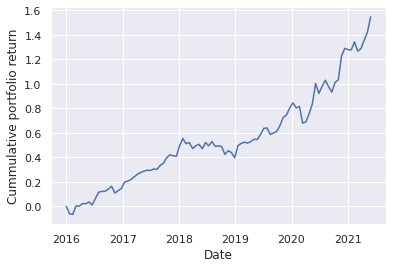

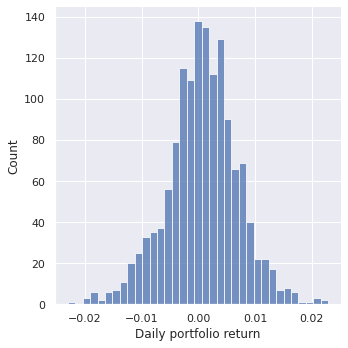

In [19]:
baseline_weights = backtest(equally_weighted_port, train, test, n=train.shape[1])

### Risk aversion = 1

Cummulative portfolio return: 4.946411092954581
Annualized sharpe ratio: 1.1347082050042863


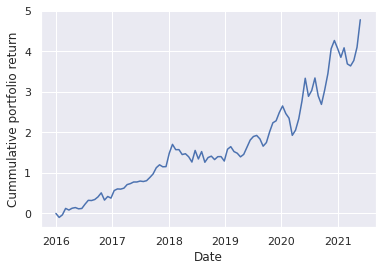

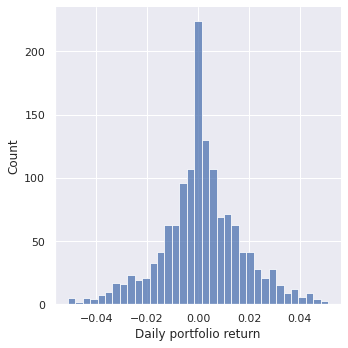

In [20]:
weights_1 = backtest(calculate_weights, train, test, risk_aversion=1., gamma=0.5, expected_return_method='ema')

Cummulative portfolio return: 4.663751808548375
Annualized sharpe ratio: 1.1472277156380575


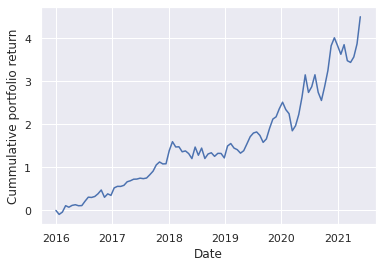

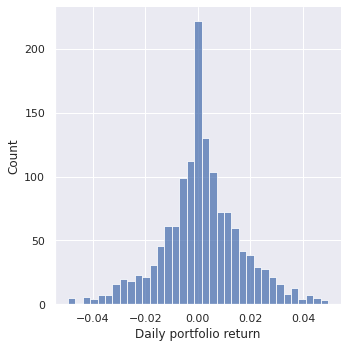

In [21]:
nco_weights_1 = backtest(nco, train, test, allocation_method=allocate_weights, risk_aversion=1., gamma=0.5)

### Risk aversion = 30

Cummulative portfolio return: 2.9685962450180527
Annualized sharpe ratio: 1.3819862215478678


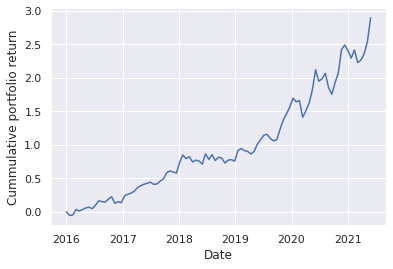

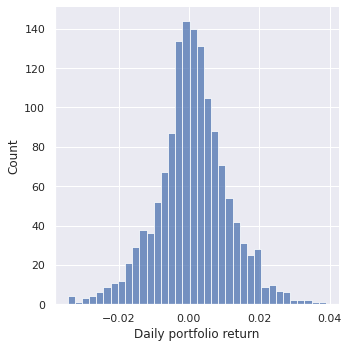

In [22]:
weights_30 = backtest(calculate_weights, train, test, risk_aversion=30., gamma=0.5, expected_return_method='ema')

Cummulative portfolio return: 3.0220331988593907
Annualized sharpe ratio: 1.3074596571952803


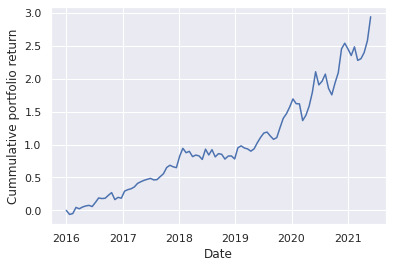

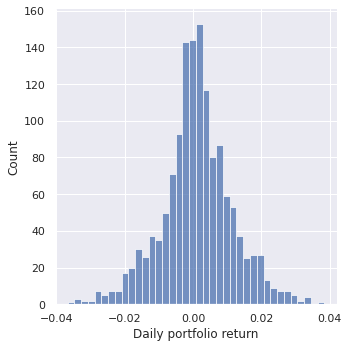

In [23]:
nco_weights_30 = backtest(nco, train, test, allocation_method=allocate_weights, risk_aversion=30., gamma=0.5)

### Risk aversion = 70

Cummulative portfolio return: 1.8972321353980597
Annualized sharpe ratio: 1.809987222735216


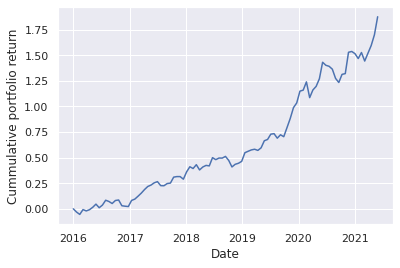

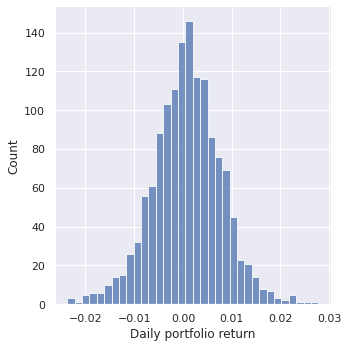

In [24]:
weights_70 = backtest(calculate_weights, train, test, risk_aversion=70., gamma=0.5, expected_return_method='ema')

Cummulative portfolio return: 1.5745382780591903
Annualized sharpe ratio: 1.856058038175357


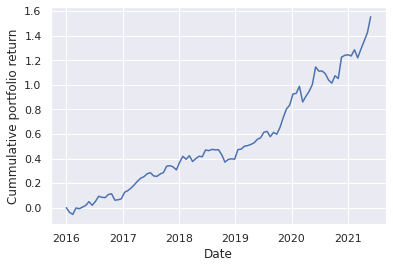

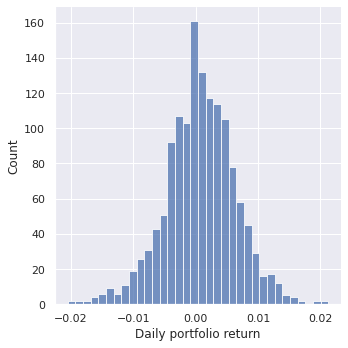

In [25]:
nco_weights_70 = backtest(nco, train, test, allocation_method=allocate_weights, risk_aversion=70., gamma=0.5)

## Conclusion

When we operating with returns, it's mean and covariance are extremely small, that's why optimization methods are suffered from gradient vanishing problem. I've fixed it a bit with scaling.

As we can see methods were tested on bull market, that's why more risky strategies gained more. Now there is low market because of geo-political and other reasons, so during next 5 years I expect market growth. That's why I choose more risky strategy for long-horizon (at least 5 years) portfolio

From evaluation I can't say that NCO improved or declined results, it requires more precise evaluation probably on other datasets

Weights for portfolio

In [27]:
pd.DataFrame({'weight': weights_30}, index=test.columns)

,weight
Argentina: BNY Mellon Argentina ADR,4.158017e-16
Argentina: BNY Mellon Argentina ADR TR,1.284220e-16
Argentina: S&P Merval,6.563703e-02
Argentina: S&P/BYMA Argentina General,3.857070e-03
Australia: ASX All Ordinaries,0.000000e+00
...,...
World: TR/CC CRB ex Energy ER,0.000000e+00
World: TR/CC CRB ex Energy TR,6.844922e-17
World: WTI Futures Long USD,1.203871e-16
World: World Water CW,9.453527e-18
